In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import pickle

In [59]:
# Loading CO2 data -> https://app.electricitymaps.com/map
file_path = 'datasets/CA-QC_2023_hourly.csv'
co2 = pd.read_csv(file_path)
tmp_df = co2[['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)']][0:1345].copy()

# Loading temperature records in Montreal
#  Reference: CANADA Environment and natural resources -> https://climate.weather.gc.ca/climate_data/hourly_data_e.html?hlyRange=2008-01-08%7C2024-05-26&dlyRange=2002-12-23%7C2024-05-26&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_e.html&searchType=stnProx&optLimit=yearRange&StartYear=2023&EndYear=2023&selRowPerPage=25&Line=2&txtRadius=25&optProxType=city&selCity=45%7C31%7C73%7C39%7CMontr%C3%A9al&selPark=&txtCentralLatDeg=&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongDeg=&txtCentralLongMin=0&txtCentralLongSec=0&txtLatDecDeg=&txtLongDecDeg=&timeframe=1&time=LST&time=LST&Year=2023&Month=2&Day=25#
file_path = 'datasets/temp.csv'
temp = pd.read_csv(file_path)
tmp_df['Temp (°C)'] = temp['Temp (°C)'][0:1345].copy()
tmp_df['Emission [gCO₂eq/kWh]'] = tmp_df['Carbon Intensity gCO₂eq/kWh (direct)'] + tmp_df['Carbon Intensity gCO₂eq/kWh (LCA)']

# Set Datetime as index
tmp_df.set_index('Datetime (UTC)', inplace=True)

tmp_df.index = pd.to_datetime(tmp_df.index)

# Resample DataFrame to 5-minute intervals and interpolate
tmp_df = tmp_df.resample('5T').interpolate(method='linear')

### Loading wholesale market price for HQ (https://www.nyiso.com/custom-reports)

# Load the CSV file
file_path = 'datasets/HQRTLMP.csv'
data = pd.read_csv(file_path, parse_dates=['RTD End Time Stamp'])

# Filter the records from 2023-01-01 00:00:00 to 2023-02-26 00:00:00
start_date = '2023-01-01 00:00:00'
end_date = '2023-02-26 00:00:00'
filtered_data = data[(data['RTD End Time Stamp'] >= start_date) & (data['RTD End Time Stamp'] <= end_date)]

# Remove duplicates by keeping the first occurrence
filtered_data = filtered_data.drop_duplicates(subset=['RTD End Time Stamp'])

# Generate expected timestamps
expected_timestamps = pd.date_range(start=start_date, end=end_date, freq='5T')

# Set the RTD End Time Stamp column as index
filtered_data.set_index('RTD End Time Stamp', inplace=True)

# Reindex the dataframe to insert missing intervals
filtered_data = filtered_data.reindex(expected_timestamps)

# Forward fill missing values
filtered_data['RTD Zonal LBMP'].fillna(method='ffill', inplace=True)

# Reset index to get RTD End Time Stamp back as a column
filtered_data.reset_index(inplace=True)
filtered_data.rename(columns={'index': 'RTD End Time Stamp'}, inplace=True)

# Keep only the 'RTD End Time Stamp' and 'RTD Zonal LBMP' columns
HQRTLMP = filtered_data[['RTD End Time Stamp', 'RTD Zonal LBMP']].copy()
HQRTLMP.rename(columns={'RTD End Time Stamp': 'Time', 'RTD Zonal LBMP': 'P'}, inplace=True)
HQRTLMP.P *= 1.3511/1000 #changed price from US$/MWh to CA$/kWh -> usd to cad conversion rate average for the last year on 5/16/2024 was 1.3511, 
HQRTLMP.set_index('Time', inplace=True)

tmp_df = tmp_df.join(HQRTLMP, how='inner')

### desired Temperature
# Define transition and working hours in 5-minute intervals
transition_intervals = 12  # 1 hour
work_start = 9 * 12
work_end = 17 * 12

# Create a single day temperature profile
day_profile = np.ones(24 * 12) * 18
day_profile[work_start:work_end] = 22

# Smooth transition up
for i in range(transition_intervals):
    day_profile[work_start - transition_intervals + i] = 18 + (4 * i) / transition_intervals

# Smooth transition down
for i in range(transition_intervals):
    day_profile[work_end + i] = 22 - (4 * i) / transition_intervals

# Repeat the daily profile to create a weekly profile
T_des = np.tile(day_profile, 56)

last_item = T_des[-1]  # Get the last item in T_des
T_des = np.append(T_des, last_item)  # Append the last item to T_des
tmp_df['Des Temp [°C]'] = T_des


tmp_df

,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),Temp (°C),Emission [gCO₂eq/kWh],P,Des Temp [°C]
Datetime (UTC),,,,,,
2023-01-01 00:00:00,0.540000,28.210000,3.900000,28.750000,0.035169,18.0
2023-01-01 00:05:00,0.553333,28.235833,3.883333,28.789167,0.032507,18.0
2023-01-01 00:10:00,0.566667,28.261667,3.866667,28.828333,0.027914,18.0
2023-01-01 00:15:00,0.580000,28.287500,3.850000,28.867500,0.037439,18.0
2023-01-01 00:20:00,0.593333,28.313333,3.833333,28.906667,0.036953,18.0
...,...,...,...,...,...,...
2023-02-25 23:40:00,0.380000,27.196667,-15.033333,27.576667,0.029116,18.0
2023-02-25 23:45:00,0.335000,27.150000,-14.925000,27.485000,0.029292,18.0
2023-02-25 23:50:00,0.290000,27.103333,-14.816667,27.393333,0.030535,18.0


In [86]:
db = pd.read_csv('datasets/ds4-Varennes-library.csv')
df = db[['Time', 'cons_noheating [kW]', 'T_ext', 'light_cons [kW]', 'heating_total [kW]', 'prod [kW]']].copy()
df.loc[:,'non_reducible'] = df['cons_noheating [kW]'] - df['light_cons [kW]']
# df['non_reducible'][df['non_reducible']<0] = 0
for i in df.index:
    if df.loc[i, 'non_reducible'] < 0:
        df.loc[i, 'non_reducible'] = (df.loc[i-1, 'non_reducible'] + df.loc[i+1, 'non_reducible']) / 2
time_range = pd.date_range(start='2018-01-01 00:00:00', end='2018-03-01 23:45:00', freq='15T')
df.loc[:,'Time'] = time_range
# df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Resample to 5-minute intervals
data = df.resample('5T').asfreq()

# Extract hour and minute
data['hour'] = data.index.hour
data['minute'] = data.index.minute

# Calculate sin and cos
data['cos'] = (np.cos(2 * np.pi * (data['hour']*60 + data['minute']) / (24*60)) + 1) / 2
data['sin'] = (np.sin(2 * np.pi * (data['hour']*60 + data['minute']) / (24*60)) + 1) / 2

# Drop the 'hour' column
data = data.drop(columns=['hour', 'minute'])
data = data[0:16129].copy()

# Interpolate 'T_ext'
data['Temp [°C]'] = tmp_df['Temp (°C)'].to_numpy()
data[['Carbon Intensity [gCO₂eq/kWh] (direct)', 'Carbon Intensity [gCO₂eq/kWh] (LCA)', 'Total Emission [gCO₂eq/kWh]']] = tmp_df[['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)', 'Emission [gCO₂eq/kWh]']].to_numpy()

# data['pv [kWh]'] = df['prod [kW]'].reindex(data.index).ffill().bfill() * (4/3) / 3
data['non_reducible [kWh]'] = df['non_reducible'].reindex(data.index).ffill().bfill() * (4/3) / 3
data['reducible [kWh]'] = df['light_cons [kW]'].reindex(data.index).ffill().bfill() * (4/3) / 3
data.drop(['cons_noheating [kW]', 'heating_total [kW]', 'light_cons [kW]', 'T_ext', 'prod [kW]', 'non_reducible'], axis = 1, inplace=True)


# Adding wholesale market price to df
data['P [$/kWh]'] = tmp_df['P'].to_numpy()


## adding des temp
data['Des Temp [°C]'] = tmp_df['Des Temp [°C]'].to_numpy()

def check_time_range(row):
    hour = row.name.hour
    # Check if hour is in the range 6-9 AM or 4-8 PM
    return 1 if (6 <= hour < 9) or (16 <= hour < 20) else 0

# Apply the function to each row to create a new column
data['peak'] = data.apply(check_time_range, axis=1)


def check_working_day(row):
    wd = row.name.weekday()
    # Check if hour is in the range 6-9 AM or 4-8 PM
    return 0 if wd >= 5 else 1

# Apply the function to each row to create a new column
data['working_day'] = data.apply(check_working_day, axis=1)

# Save dataframes
with open('datasets/df.pkl', 'wb') as f:
  pickle.dump(data, f)

data

,cos,sin,Temp [°C],Carbon Intensity [gCO₂eq/kWh] (direct),Carbon Intensity [gCO₂eq/kWh] (LCA),Total Emission [gCO₂eq/kWh],non_reducible [kWh],reducible [kWh],P [$/kWh],Des Temp [°C],peak,working_day
Time,,,,,,,,,,,,
2018-01-01 00:00:00,1.000000,0.500000,3.900000,0.540000,28.210000,28.750000,3.272667,0.0,0.035169,18.0,0,1
2018-01-01 00:05:00,0.999881,0.510907,3.883333,0.553333,28.235833,28.789167,3.272667,0.0,0.032507,18.0,0,1
2018-01-01 00:10:00,0.999524,0.521810,3.866667,0.566667,28.261667,28.828333,3.272667,0.0,0.027914,18.0,0,1
2018-01-01 00:15:00,0.998929,0.532702,3.850000,0.580000,28.287500,28.867500,2.886444,0.0,0.037439,18.0,0,1
2018-01-01 00:20:00,0.998097,0.543578,3.833333,0.593333,28.313333,28.906667,2.886444,0.0,0.036953,18.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-25 23:40:00,0.998097,0.456422,-15.033333,0.380000,27.196667,27.576667,3.840000,0.0,0.029116,18.0,0,0
2018-02-25 23:45:00,0.998929,0.467298,-14.925000,0.335000,27.150000,27.485000,2.263222,0.0,0.029292,18.0,0,0
2018-02-25 23:50:00,0.999524,0.478190,-14.816667,0.290000,27.103333,27.393333,2.263222,0.0,0.030535,18.0,0,0


In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pickle
import itertools
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

class REF_Model:
    def __init__(self, day, C, R, h):
        self.day = day
        self.C = C
        self.R = R
        self.h = h
        self.T = 24 * 12
        self.load_temperature_data()
        self.model = None
        self.B_values = None
        self.T_in_ref_values = None

    def load_temperature_data(self):
        with open(r'datasets/df.pkl', 'rb') as f:
            db = pickle.load(f)
        self.T_out = np.array(db.iloc[self.T*(self.day-1):self.T*self.day,:]['Temp [°C]']).reshape(self.T)
        self.T_des = np.array(db.iloc[self.T*(self.day-1):self.T*self.day,:]['Des Temp [°C]']).reshape(self.T)
    
    def setup_model(self):
        self.model = gp.Model("HVAC_Optimization")
        self.model.setParam('OutputFlag', 0)
        self.model.setParam('MIPGap', 0.01)
        self.model.setParam('TimeLimit', 5000)
        # self.model.setParam('MIPGap', 0.07)
        # self.model.setParam('TimeLimit', 200)
        B_ref = self.model.addVars(self.T, vtype=GRB.BINARY, name="B_ref")
        T_in_ref = self.model.addVars(self.T, lb=-GRB.INFINITY, name="T_in_ref")
        y = self.model.addVars(self.T, name="y")
        obj_ref = gp.quicksum(y[t] for t in range(self.T))
        self.model.setObjective(obj_ref, GRB.MINIMIZE)
        self.model.addConstr(T_in_ref[0] == self.T_des[0])
        for t in range(1, self.T):
            self.model.addConstr(T_in_ref[t] == T_in_ref[t-1] + ((self.T_out[t] - T_in_ref[t-1])/self.R + B_ref[t]*self.h)*(5/self.C), name=f"Temperature_{t}")
            self.model.addConstr(y[t] >= self.T_des[t] - T_in_ref[t], name=f"Linearization_pos_{t}")
            self.model.addConstr(y[t] >= -(self.T_des[t] - T_in_ref[t]), name=f"Linearization_neg_{t}")

    def solve(self):
        self.setup_model()
        self.model.optimize()
        self.B_values = [self.model.getVarByName(f"B_ref[{t}]").x for t in range(self.T)]
        self.T_in_ref_values = [self.model.getVarByName(f"T_in_ref[{t}]").x for t in range(self.T)]

    def get_results(self):
        return self.B_values, self.T_in_ref_values

def run_simulation(params):
    day, C, R, h = params
    model = REF_Model(day, C, R, h)
    model.solve()
    return params, model.get_results()

def run_for_all_combinations():
    results = {}
    days = range(1, 57)
    C_values = [100, 150]
    R_values = [1, 2]
    h_values = [50, 80]

    combinations = list(itertools.product(days, C_values, R_values, h_values))
    progress_bar = tqdm(total=len(combinations), desc='Processing')

    with ThreadPoolExecutor() as executor:
        future_to_params = {executor.submit(run_simulation, params): params for params in combinations}
        for future in as_completed(future_to_params):
            params, result = future.result()
            progress_bar.update(1)
            results[params] = result

    progress_bar.close()
    with open('datasets/ref_res.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

# Call the function to run the model for all combinations and get results
results = run_for_all_combinations()


Processing: 100%|██████████| 448/448 [19:41:39<00:00, 158.26s/it]    


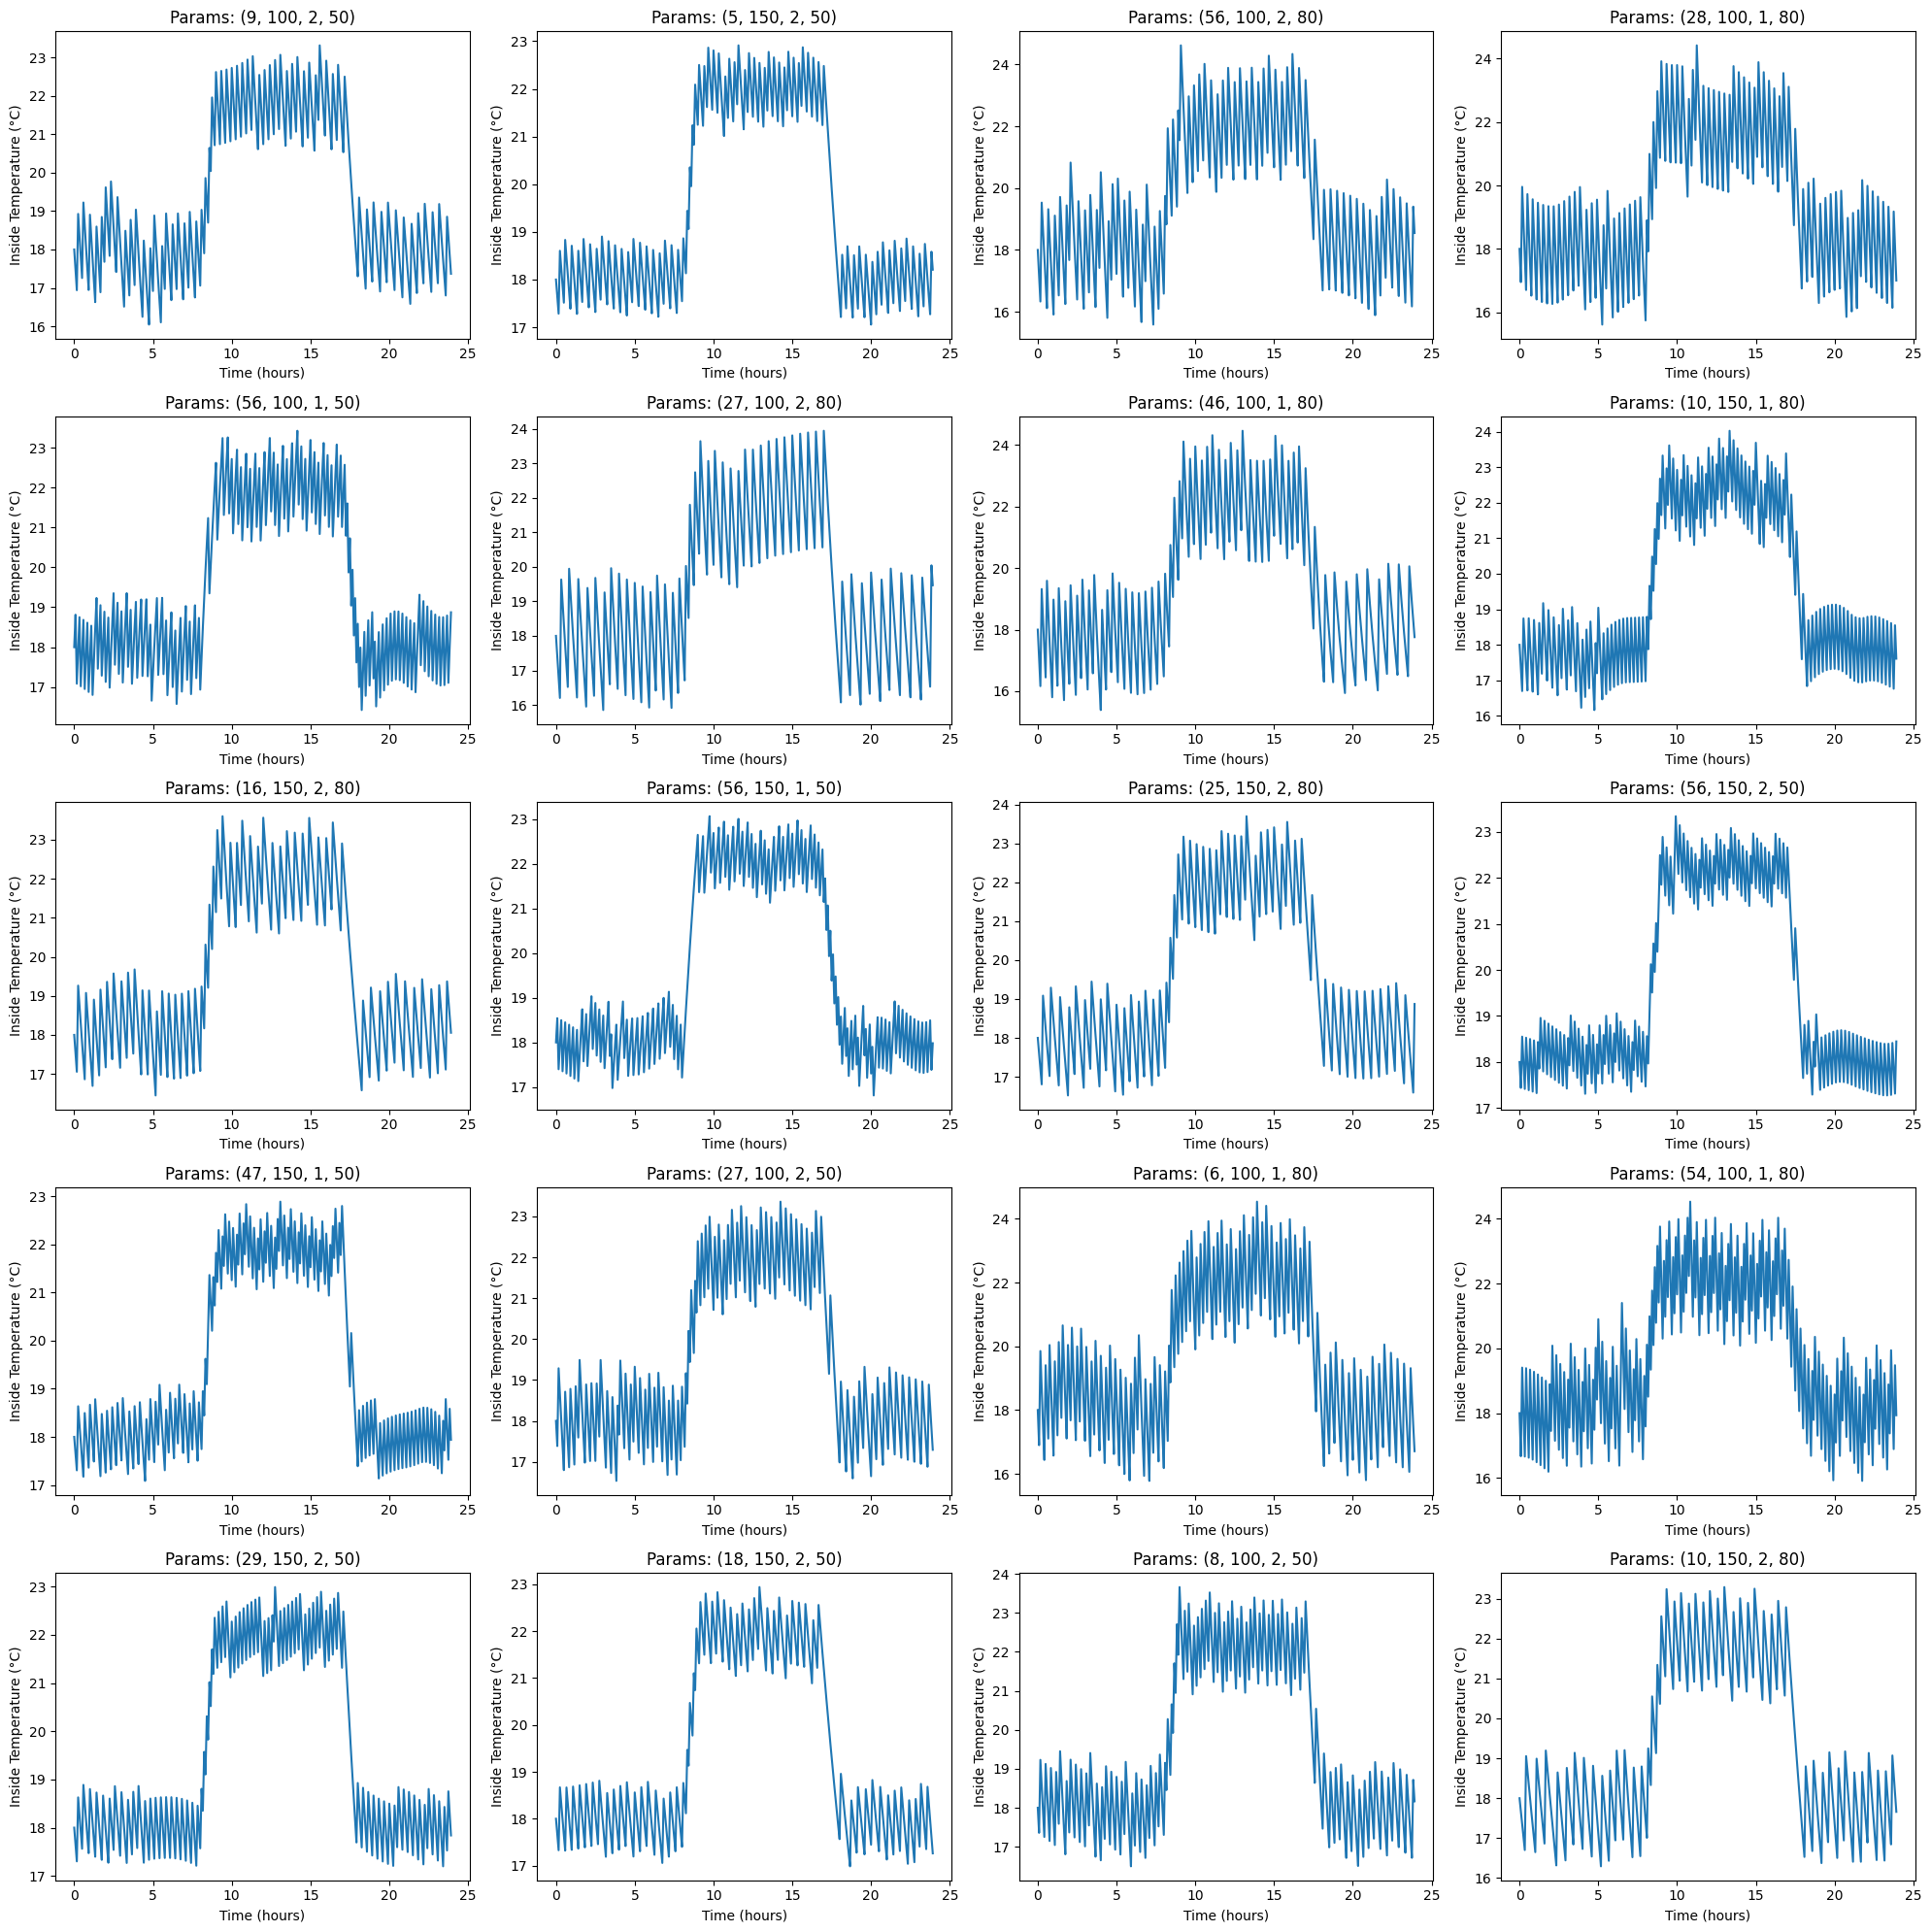

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the saved results
with open('datasets/ref_res.pkl', 'rb') as f:
    results = pickle.load(f)

# Select 20 random parameter combinations
random_params = random.sample(list(results.keys()), 20)

# Time steps in a day with 5-minute intervals
time_steps = np.arange(24 * 12) * 5 / 60

# Create plots for each selected parameter combination
fig, axs = plt.subplots(5, 4, figsize=(20, 20))  # Adjust subplot layout as needed
axs = axs.flatten()

for i, params in enumerate(random_params):
    T_in_ref_values = results[params][1]
    axs[i].plot(time_steps, T_in_ref_values)
    axs[i].set_title(f'Params: {params}')
    axs[i].set_xlabel('Time (hours)')
    axs[i].set_ylabel('Inside Temperature (°C)')

plt.tight_layout()
plt.show()
